In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

**Перед тем как начать выполнять задание, определитесь где вы будете обучать модель: на GPU или CPU.**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Проблема затухания градиента

Рассмотрим проблему затухания градиента во время обучений неройнных сетей

**Залача 1:** Определите модель со следующей структурой:
1. Вход и выход заданы - линейными слоями (nn.Linear)
2. Скрытые слои - в виде линейных слоев в nn.ModuleList

In [3]:
# Класс модели:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x))
        x = self.output_layer(x)
        return x


**Вопрос:** Сколько параметров (весов) будет иметь эта модель, если инициализировать ее следующие аргументами:

input_size=3, 
hidden_size=6,
output_size=7,
n_hidden=1

**Пример ответа:** `123`

In [4]:
model = DeepMLP(input_size=3, hidden_size=6,output_size=7,n_hidden=1)
answer = sum(w.numel() for w in model.parameters())
answer # 115

115

**Задача 2:** Вычислите среднее по градиенту в первом скрытом (!!!) слое.

**Вопрос:** Каково это значение?

**Пример ответа:** `1.2`

In [5]:
torch.manual_seed(42)

model = DeepMLP(28 * 28, 6, 7, 1)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.zero_grad()
out = model(torch.rand((1, 28 * 28)))
loss = criterion(out, torch.rand((1, )).long())

loss.backward()

In [ ]:
answer = model.hidden_layers[0].weight.grad.mean().item()
answer # 0.0010385029017925262


0.0010385029017925262

Теперь попробуйте обучить небольшую модель состоящую всего-лишь из трех скрытых слоев.

**Задача 3:** Создайте объект класса модели DeepMLP

In [11]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10 # 10 классов MNIST
n_hidden=3          # небольшая модель всего из трех скрытых слоев
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Какова сумма всех выходов модели для случайного входного тензора test_data?

**Пример ответа:** `1.234`

In [ ]:
test_data = torch.rand((1, 28*28)).to(device)

answer = model(test_data).sum().item()
answer # -0.5515778064727783

-0.5515778064727783

Теперь попробуем имплементировать цикл обучения и затем обучить модель на датасете MNIST. Но для начала давайте скачаем и подготовим этот датасет для обучения:

In [13]:
# Загрузка и подготовка датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 144kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.12MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.56MB/s]


In [14]:
# Опишем цикл обучения:
def train(model, trainloader, criterion, optimizer):
  torch.manual_seed(42)

  model.train()

  fc_gradients = []

  for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      loss.backward()
      optimizer.step()

      if step % 10 == 0:
        print(f'Step: {step}, Loss: {loss}')
        
      fc_gradients.append(model.hidden_layers[0].weight.grad.mean().item())  # <------ код из решения задачи 2

  return fc_gradients

In [15]:
# Теперь обучим модель:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

_ = train(model, trainloader, criterion, optimizer)

  3%|▎         | 26/938 [00:02<01:04, 14.20it/s]

Step: 0, Loss: 2.2937896251678467
Step: 10, Loss: 2.2889366149902344
Step: 20, Loss: 2.2910501956939697
Step: 30, Loss: 2.154608964920044
Step: 40, Loss: 2.0164732933044434
Step: 50, Loss: 1.8274619579315186


 11%|█         | 102/938 [00:02<00:11, 75.99it/s]

Step: 60, Loss: 1.683337688446045
Step: 70, Loss: 1.580724835395813
Step: 80, Loss: 1.5134083032608032
Step: 90, Loss: 1.4839725494384766
Step: 100, Loss: 1.3082810640335083


 16%|█▌        | 149/938 [00:03<00:06, 121.65it/s]

Step: 110, Loss: 1.525537371635437
Step: 120, Loss: 1.2212271690368652
Step: 130, Loss: 1.198136568069458
Step: 140, Loss: 1.532899022102356
Step: 150, Loss: 1.4099112749099731
Step: 160, Loss: 1.3025422096252441


 21%|██▏       | 200/938 [00:03<00:04, 169.88it/s]

Step: 170, Loss: 1.2258498668670654
Step: 180, Loss: 1.3075964450836182
Step: 190, Loss: 0.9966344237327576
Step: 200, Loss: 0.8094055652618408
Step: 210, Loss: 1.2798312902450562
Step: 220, Loss: 1.165363073348999


 30%|██▉       | 278/938 [00:03<00:03, 217.70it/s]

Step: 230, Loss: 1.0180504322052002
Step: 240, Loss: 1.025296926498413
Step: 250, Loss: 1.0189836025238037
Step: 260, Loss: 0.960390031337738
Step: 270, Loss: 0.8671618103981018


 32%|███▏      | 303/938 [00:03<00:02, 225.76it/s]

Step: 280, Loss: 0.9865818023681641
Step: 290, Loss: 1.0258790254592896
Step: 300, Loss: 1.251539707183838
Step: 310, Loss: 0.830844521522522
Step: 320, Loss: 0.967064380645752


 40%|████      | 379/938 [00:03<00:02, 235.12it/s]

Step: 330, Loss: 1.006798267364502
Step: 340, Loss: 0.7631887197494507
Step: 350, Loss: 0.9838067293167114
Step: 360, Loss: 0.9603957533836365
Step: 370, Loss: 0.9713491797447205


 43%|████▎     | 404/938 [00:04<00:02, 232.82it/s]

Step: 380, Loss: 0.9232667088508606
Step: 390, Loss: 0.7476871609687805
Step: 400, Loss: 1.0440927743911743
Step: 410, Loss: 0.7138468027114868
Step: 420, Loss: 0.8185391426086426


 51%|█████     | 480/938 [00:04<00:01, 241.64it/s]

Step: 430, Loss: 0.7134737968444824
Step: 440, Loss: 0.730175793170929
Step: 450, Loss: 0.5549497604370117
Step: 460, Loss: 0.941782534122467
Step: 470, Loss: 0.6018438339233398


 57%|█████▋    | 531/938 [00:04<00:01, 245.03it/s]

Step: 480, Loss: 0.6134659647941589
Step: 490, Loss: 0.8149213194847107
Step: 500, Loss: 1.0050498247146606
Step: 510, Loss: 0.8293569684028625
Step: 520, Loss: 0.9351283311843872
Step: 530, Loss: 1.051263451576233


 62%|██████▏   | 582/938 [00:04<00:01, 246.92it/s]

Step: 540, Loss: 0.7672565579414368
Step: 550, Loss: 0.7662622928619385
Step: 560, Loss: 0.8446758389472961
Step: 570, Loss: 1.0112249851226807
Step: 580, Loss: 0.9176709651947021
Step: 590, Loss: 1.1760613918304443


 67%|██████▋   | 632/938 [00:05<00:01, 242.28it/s]

Step: 600, Loss: 0.7197832465171814
Step: 610, Loss: 0.808471143245697
Step: 620, Loss: 0.6378464102745056
Step: 630, Loss: 0.8269914388656616
Step: 640, Loss: 0.7192348837852478


 73%|███████▎  | 682/938 [00:05<00:01, 241.38it/s]

Step: 650, Loss: 0.7457076907157898
Step: 660, Loss: 0.7320868968963623
Step: 670, Loss: 1.2856744527816772
Step: 680, Loss: 1.189614176750183
Step: 690, Loss: 1.1077910661697388


 78%|███████▊  | 731/938 [00:05<00:00, 233.53it/s]

Step: 700, Loss: 0.8198347091674805
Step: 710, Loss: 0.8690475225448608
Step: 720, Loss: 0.7203513383865356
Step: 730, Loss: 0.7186920046806335
Step: 740, Loss: 0.6397549510002136
Step: 750, Loss: 0.4731939733028412


 86%|████████▌ | 805/938 [00:05<00:00, 237.43it/s]

Step: 760, Loss: 0.8411208391189575
Step: 770, Loss: 0.8321958780288696
Step: 780, Loss: 0.648811399936676
Step: 790, Loss: 0.8235577344894409
Step: 800, Loss: 0.5993244051933289


 88%|████████▊ | 829/938 [00:05<00:00, 236.51it/s]

Step: 810, Loss: 0.6706565618515015
Step: 820, Loss: 0.915051281452179
Step: 830, Loss: 0.6087186932563782
Step: 840, Loss: 0.7651242017745972


 93%|█████████▎| 876/938 [00:06<00:00, 214.27it/s]

Step: 850, Loss: 1.1403437852859497
Step: 860, Loss: 0.6345685124397278
Step: 870, Loss: 0.5910040140151978
Step: 880, Loss: 0.6195895075798035
Step: 890, Loss: 0.7881004810333252


 99%|█████████▊| 925/938 [00:06<00:00, 213.41it/s]

Step: 900, Loss: 0.8610857725143433
Step: 910, Loss: 0.7456798553466797
Step: 920, Loss: 0.7235593199729919
Step: 930, Loss: 0.6586704254150391


100%|██████████| 938/938 [00:06<00:00, 134.42it/s]


Как вы можете видеть, модель сходится, хотя и не очень хорошо. Вы должны получить лосс в диапазоне 0.5-0.9. Низкая производительность модели обусловлена тем, что трех скрытых слоев недостаточно чтобы хорошо обучить эту модель классифицировать MNIST датасет.

Теперь попробуйте увеличить количество скрытых слоев до 10 и обучить модель еще раз.

**Задача 4:** Увеличьте число скрытых слоев до 10.

In [16]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden = 10 # 
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите количество скрытых слоев модели.

**Пример ответа:** `3`

In [17]:
answer = len(list(model.hidden_layers))
answer   # 10

10

In [18]:
# Обучите модель еще раз:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

fc_gradients = train(model, trainloader, criterion, optimizer)

  3%|▎         | 27/938 [00:02<01:03, 14.27it/s]

Step: 0, Loss: 2.3116233348846436
Step: 10, Loss: 2.2927768230438232
Step: 20, Loss: 2.3289730548858643
Step: 30, Loss: 2.3101611137390137
Step: 40, Loss: 2.3166162967681885
Step: 50, Loss: 2.334523916244507


 11%|█         | 99/938 [00:02<00:11, 71.60it/s]

Step: 60, Loss: 2.3023855686187744
Step: 70, Loss: 2.3015942573547363
Step: 80, Loss: 2.3111732006073
Step: 90, Loss: 2.2828001976013184
Step: 100, Loss: 2.3095765113830566


 15%|█▌        | 145/938 [00:03<00:06, 115.95it/s]

Step: 110, Loss: 2.2963788509368896
Step: 120, Loss: 2.2688262462615967
Step: 130, Loss: 2.2773725986480713
Step: 140, Loss: 2.292206048965454
Step: 150, Loss: 2.307490348815918
Step: 160, Loss: 2.3057727813720703


 21%|██        | 195/938 [00:03<00:04, 163.78it/s]

Step: 170, Loss: 2.292785167694092
Step: 180, Loss: 2.2967798709869385
Step: 190, Loss: 2.303372621536255
Step: 200, Loss: 2.2963035106658936
Step: 210, Loss: 2.3021485805511475


 29%|██▊       | 268/938 [00:03<00:03, 205.34it/s]

Step: 220, Loss: 2.320111036300659
Step: 230, Loss: 2.2967655658721924
Step: 240, Loss: 2.3166937828063965
Step: 250, Loss: 2.300534963607788
Step: 260, Loss: 2.3093209266662598


 31%|███       | 292/938 [00:03<00:03, 211.82it/s]

Step: 270, Loss: 2.3047688007354736
Step: 280, Loss: 2.2988860607147217
Step: 290, Loss: 2.2999863624572754
Step: 300, Loss: 2.313730478286743
Step: 310, Loss: 2.2899210453033447


 39%|███▊      | 362/938 [00:04<00:02, 220.98it/s]

Step: 320, Loss: 2.3008487224578857
Step: 330, Loss: 2.2937445640563965
Step: 340, Loss: 2.308018684387207
Step: 350, Loss: 2.3129148483276367
Step: 360, Loss: 2.2795770168304443


 43%|████▎     | 408/938 [00:04<00:02, 213.85it/s]

Step: 370, Loss: 2.301941156387329
Step: 380, Loss: 2.303889274597168
Step: 390, Loss: 2.303920030593872
Step: 400, Loss: 2.319232702255249
Step: 410, Loss: 2.304791212081909


 49%|████▉     | 458/938 [00:04<00:02, 230.26it/s]

Step: 420, Loss: 2.3087210655212402
Step: 430, Loss: 2.301931858062744
Step: 440, Loss: 2.3054850101470947
Step: 450, Loss: 2.3106303215026855
Step: 460, Loss: 2.2992069721221924
Step: 470, Loss: 2.299790143966675


 54%|█████▍    | 508/938 [00:04<00:01, 237.34it/s]

Step: 480, Loss: 2.2870547771453857
Step: 490, Loss: 2.300715208053589
Step: 500, Loss: 2.305913209915161
Step: 510, Loss: 2.306124210357666
Step: 520, Loss: 2.296645402908325
Step: 530, Loss: 2.298403024673462


 62%|██████▏   | 585/938 [00:05<00:01, 247.77it/s]

Step: 540, Loss: 2.3022847175598145
Step: 550, Loss: 2.3009307384490967
Step: 560, Loss: 2.29413104057312
Step: 570, Loss: 2.3121469020843506
Step: 580, Loss: 2.307267665863037


 68%|██████▊   | 635/938 [00:05<00:01, 247.57it/s]

Step: 590, Loss: 2.3139257431030273
Step: 600, Loss: 2.295274257659912
Step: 610, Loss: 2.32055926322937
Step: 620, Loss: 2.2999744415283203
Step: 630, Loss: 2.311312198638916


 73%|███████▎  | 686/938 [00:05<00:01, 247.71it/s]

Step: 640, Loss: 2.2809951305389404
Step: 650, Loss: 2.298368453979492
Step: 660, Loss: 2.306234121322632
Step: 670, Loss: 2.292137384414673
Step: 680, Loss: 2.3122923374176025


 78%|███████▊  | 736/938 [00:05<00:00, 241.65it/s]

Step: 690, Loss: 2.3026340007781982
Step: 700, Loss: 2.3024535179138184
Step: 710, Loss: 2.2988359928131104
Step: 720, Loss: 2.316863775253296
Step: 730, Loss: 2.3063318729400635


 81%|████████  | 761/938 [00:05<00:00, 236.54it/s]

Step: 740, Loss: 2.2941946983337402
Step: 750, Loss: 2.2960400581359863
Step: 760, Loss: 2.3012545108795166
Step: 770, Loss: 2.3173437118530273
Step: 780, Loss: 2.2927865982055664


 86%|████████▋ | 810/938 [00:05<00:00, 229.75it/s]

Step: 790, Loss: 2.2951316833496094
Step: 800, Loss: 2.2958858013153076
Step: 810, Loss: 2.3131909370422363
Step: 820, Loss: 2.3094005584716797
Step: 830, Loss: 2.3140487670898438


 94%|█████████▍| 884/938 [00:06<00:00, 238.49it/s]

Step: 840, Loss: 2.3108713626861572
Step: 850, Loss: 2.3054325580596924
Step: 860, Loss: 2.3024678230285645
Step: 870, Loss: 2.2862765789031982
Step: 880, Loss: 2.297034978866577
Step: 890, Loss: 2.3039724826812744


 99%|█████████▉| 932/938 [00:06<00:00, 224.88it/s]

Step: 900, Loss: 2.301696300506592
Step: 910, Loss: 2.2977378368377686
Step: 920, Loss: 2.29618763923645
Step: 930, Loss: 2.297502040863037


100%|██████████| 938/938 [00:07<00:00, 132.50it/s]


Как вы можете видеть, лосс прекратил уменьшаться. Почему так произошло? Давайте визуализируем градиент для первого скрытого слоя (который записан в переменную fc_gradients; остальные скрытые слои будут иметь похожий градиена, так что опустим их).

C:\Users\khari\AppData\Local\Temp\ipykernel_2364\2019969697.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


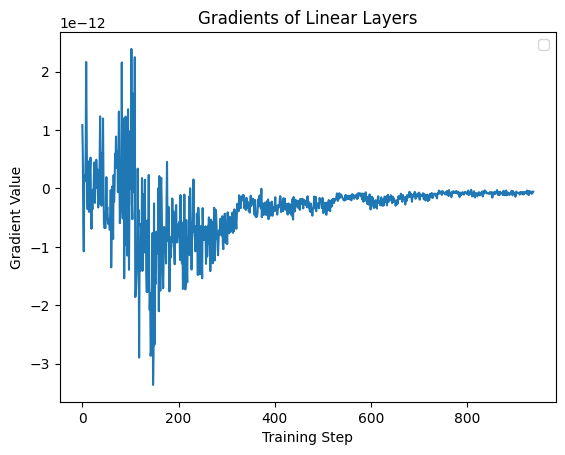

In [19]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, после примерно 300 итерации градиент начал *затухать*, что означает, что веса скрытых слоев перестали обучаться. По этой причине лосс и перестал уменьшаться, т.к. градиент стал слишком мал чтобы влиять на веса слоев.

Глубокие модели (с большим числом скрытых слоев) подвержены проблеме затухания градиента, что приводит к тому, что такие модели не могут обучаться эффективно. 

Одна из причин этого (в этом примере) это использования sigmoid в качестве функции активации. Давайте изменим функцию активации на ReLU и переобучим модель еще раз.

**Задача 5:** Замените sigmoid на ReLU

In [20]:
# Замените sigmoid на ReLU:
class DeepMLP_ReLU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP_ReLU, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))  # <---- Замена Sigmoid → ReLU
        x = self.output_layer(x)
        return x

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандомного входного тензора test_input

**Пример ответа:** `0.234`

In [21]:
# Инициализируйте модель с ReLU:
torch.manual_seed(42)

input_size = 28 * 28
hidden_size = 32
output_size = 10
n_hidden=10
model_relu = DeepMLP_ReLU(input_size, hidden_size, output_size, n_hidden).to(device)

In [ ]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = answer = model(test_data).sum().item()
answer   # -0.2574273943901062

-0.2574273943901062

In [23]:
# Обучите модель с ReLU:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_relu.parameters(), lr=0.01)

fc_gradients = train(model_relu, trainloader, criterion, optimizer)

  2%|▏         | 20/938 [00:02<01:26, 10.60it/s]

Step: 0, Loss: 2.303701162338257
Step: 10, Loss: 2.2954559326171875
Step: 20, Loss: 2.302825450897217
Step: 30, Loss: 2.304783821105957
Step: 40, Loss: 2.2693960666656494


 10%|█         | 94/938 [00:02<00:11, 70.96it/s]

Step: 50, Loss: 2.2888948917388916
Step: 60, Loss: 2.2994587421417236
Step: 70, Loss: 2.233182668685913
Step: 80, Loss: 2.084224224090576
Step: 90, Loss: 2.1644632816314697


 15%|█▍        | 139/938 [00:03<00:06, 114.57it/s]

Step: 100, Loss: 1.886821985244751
Step: 110, Loss: 2.1723809242248535
Step: 120, Loss: 1.598232388496399
Step: 130, Loss: 1.674208164215088
Step: 140, Loss: 1.6234245300292969


 20%|█▉        | 187/938 [00:03<00:04, 160.08it/s]

Step: 150, Loss: 1.508836030960083
Step: 160, Loss: 1.4847134351730347
Step: 170, Loss: 1.7356793880462646
Step: 180, Loss: 1.5706602334976196
Step: 190, Loss: 1.4291819334030151


 25%|██▌       | 236/938 [00:03<00:03, 194.97it/s]

Step: 200, Loss: 1.5721112489700317
Step: 210, Loss: 1.960357427597046
Step: 220, Loss: 1.5618594884872437
Step: 230, Loss: 1.4086884260177612
Step: 240, Loss: 1.453956127166748


 30%|███       | 286/938 [00:03<00:02, 219.06it/s]

Step: 250, Loss: 1.3992490768432617
Step: 260, Loss: 1.3890862464904785
Step: 270, Loss: 1.2697968482971191
Step: 280, Loss: 1.265294075012207
Step: 290, Loss: 1.3512696027755737


 36%|███▌      | 335/938 [00:03<00:02, 216.85it/s]

Step: 300, Loss: 1.5749090909957886
Step: 310, Loss: 1.5417003631591797
Step: 320, Loss: 1.3530547618865967
Step: 330, Loss: 1.495930552482605
Step: 340, Loss: 1.4685453176498413


 41%|████      | 382/938 [00:04<00:02, 224.45it/s]

Step: 350, Loss: 1.345506191253662
Step: 360, Loss: 1.333320140838623
Step: 370, Loss: 1.5319429636001587
Step: 380, Loss: 1.3654025793075562
Step: 390, Loss: 1.398057460784912
Step: 400, Loss: 1.4814039468765259


 49%|████▉     | 458/938 [00:04<00:02, 236.27it/s]

Step: 410, Loss: 1.3183008432388306
Step: 420, Loss: 1.2539492845535278
Step: 430, Loss: 1.733925700187683
Step: 440, Loss: 1.4264130592346191
Step: 450, Loss: 1.2687060832977295


 52%|█████▏    | 484/938 [00:04<00:01, 241.80it/s]

Step: 460, Loss: 1.3777492046356201
Step: 470, Loss: 1.2218379974365234
Step: 480, Loss: 1.6541993618011475
Step: 490, Loss: 1.5916812419891357
Step: 500, Loss: 1.4248911142349243


 57%|█████▋    | 535/938 [00:04<00:01, 244.02it/s]

Step: 510, Loss: 1.5068399906158447
Step: 520, Loss: 1.3296935558319092
Step: 530, Loss: 1.3242286443710327
Step: 540, Loss: 1.3069977760314941
Step: 550, Loss: 1.4350450038909912


 63%|██████▎   | 587/938 [00:04<00:01, 249.58it/s]

Step: 560, Loss: 1.3986356258392334
Step: 570, Loss: 1.4159821271896362
Step: 580, Loss: 1.3216150999069214
Step: 590, Loss: 1.4223177433013916
Step: 600, Loss: 1.4674029350280762
Step: 610, Loss: 1.3278493881225586


 71%|███████   | 666/938 [00:05<00:01, 252.26it/s]

Step: 620, Loss: 1.1888298988342285
Step: 630, Loss: 1.8117350339889526
Step: 640, Loss: 1.0724364519119263
Step: 650, Loss: 1.280646562576294
Step: 660, Loss: 1.4627997875213623
Step: 670, Loss: 1.0950374603271484


 77%|███████▋  | 719/938 [00:05<00:00, 257.19it/s]

Step: 680, Loss: 1.2810704708099365
Step: 690, Loss: 1.429450511932373
Step: 700, Loss: 1.3103264570236206
Step: 710, Loss: 1.1412609815597534
Step: 720, Loss: 1.2906044721603394
Step: 730, Loss: 1.3592588901519775


 82%|████████▏ | 771/938 [00:05<00:00, 247.57it/s]

Step: 740, Loss: 0.9699320793151855
Step: 750, Loss: 0.8960282206535339
Step: 760, Loss: 1.3062540292739868
Step: 770, Loss: 1.4455121755599976
Step: 780, Loss: 0.9477115869522095
Step: 790, Loss: 1.182560682296753


 88%|████████▊ | 823/938 [00:05<00:00, 243.92it/s]

Step: 800, Loss: 0.9978427290916443
Step: 810, Loss: 1.0308696031570435
Step: 820, Loss: 1.215705156326294
Step: 830, Loss: 1.2706071138381958
Step: 840, Loss: 1.01678466796875


 93%|█████████▎| 873/938 [00:06<00:00, 231.30it/s]

Step: 850, Loss: 1.5969858169555664
Step: 860, Loss: 1.7826170921325684
Step: 870, Loss: 1.05157470703125
Step: 880, Loss: 1.3486883640289307
Step: 890, Loss: 1.3539173603057861


 98%|█████████▊| 923/938 [00:06<00:00, 225.45it/s]

Step: 900, Loss: 1.716688632965088
Step: 910, Loss: 1.3988972902297974
Step: 920, Loss: 1.486482858657837
Step: 930, Loss: 1.9129935503005981


100%|██████████| 938/938 [00:06<00:00, 134.50it/s]


C:\Users\khari\AppData\Local\Temp\ipykernel_2364\2806989764.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


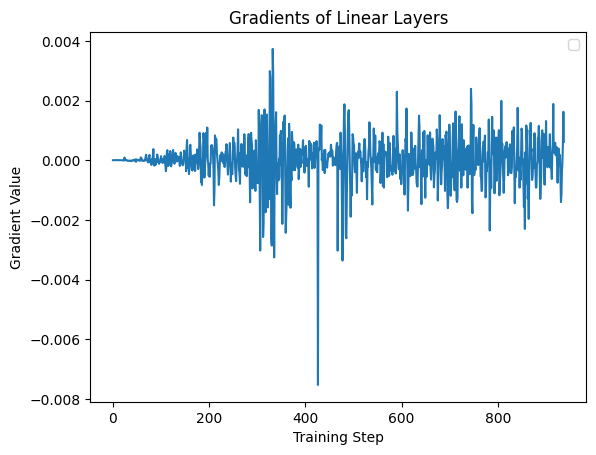

In [24]:
# Визуализируйте градинте:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Вы должны получить лосс в диапазоне 1.3-1.6. Проблема затухания градиента должна уменьшится, но не решиться полностью. Обучение глубоких нейронных сетей является нетривиальной задачей!

# Проблема взрыва градиента

Это проблема противоположна предыдущей. Вместо стремления градиента к 0, и потери способности изменять веса слоев (а значит и обучаться), градиент может "взорваться" (его значения стремятся к большим числам), что приводит к очень большим и резким изменениям весов модели, не позволяя модели сходиться.

**Задача 6:** Инициализируйте модель еще раз со следующими входными параметрами.

In [25]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 512
output_size = 10
n_hidden=20
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input (да да, еще раз)

**Пример ответа:** `0.234`

In [ ]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = model(test_data).sum().item()
answer   # -0.9367367029190063

-0.9367367029190063

In [27]:
# Обучите модель еще раз:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

fc_gradients = train(model, trainloader, criterion, optimizer)

  1%|          | 9/938 [00:02<03:10,  4.87it/s]

Step: 0, Loss: 2.370612382888794
Step: 10, Loss: 2.319352149963379


  4%|▎         | 33/938 [00:02<00:37, 24.07it/s]

Step: 20, Loss: 2.384559392929077
Step: 30, Loss: 2.322371482849121


  5%|▌         | 48/938 [00:03<00:23, 38.17it/s]

Step: 40, Loss: 2.3334953784942627
Step: 50, Loss: 2.335846185684204


  8%|▊         | 72/938 [00:03<00:15, 56.74it/s]

Step: 60, Loss: 2.337700843811035
Step: 70, Loss: 2.2949419021606445


  9%|▉         | 88/938 [00:03<00:13, 63.04it/s]

Step: 80, Loss: 2.3135998249053955
Step: 90, Loss: 2.3037657737731934


 12%|█▏        | 112/938 [00:03<00:12, 67.96it/s]

Step: 100, Loss: 2.3035049438476562
Step: 110, Loss: 2.311680316925049


 14%|█▎        | 128/938 [00:04<00:11, 67.59it/s]

Step: 120, Loss: 2.2950568199157715
Step: 130, Loss: 2.2916629314422607


 16%|█▌        | 152/938 [00:04<00:11, 69.17it/s]

Step: 140, Loss: 2.30366849899292
Step: 150, Loss: 2.308088541030884


 18%|█▊        | 168/938 [00:04<00:11, 68.89it/s]

Step: 160, Loss: 2.294508695602417
Step: 170, Loss: 2.299661636352539


 20%|██        | 191/938 [00:05<00:11, 67.88it/s]

Step: 180, Loss: 2.309527635574341
Step: 190, Loss: 2.3046488761901855


 22%|██▏       | 207/938 [00:05<00:10, 69.52it/s]

Step: 200, Loss: 2.2925260066986084
Step: 210, Loss: 2.297971487045288


 25%|██▍       | 231/938 [00:05<00:09, 71.60it/s]

Step: 220, Loss: 2.3187084197998047
Step: 230, Loss: 2.296956777572632


 26%|██▋       | 247/938 [00:05<00:09, 70.71it/s]

Step: 240, Loss: 2.320816993713379
Step: 250, Loss: 2.3015003204345703


 29%|██▉       | 271/938 [00:06<00:09, 71.80it/s]

Step: 260, Loss: 2.3070170879364014
Step: 270, Loss: 2.304478168487549


 31%|███▏      | 295/938 [00:06<00:08, 72.56it/s]

Step: 280, Loss: 2.3052568435668945
Step: 290, Loss: 2.3059656620025635


 33%|███▎      | 311/938 [00:06<00:08, 70.52it/s]

Step: 300, Loss: 2.3120129108428955
Step: 310, Loss: 2.291264295578003


 36%|███▌      | 335/938 [00:07<00:08, 71.28it/s]

Step: 320, Loss: 2.298677682876587
Step: 330, Loss: 2.296095609664917


 37%|███▋      | 350/938 [00:07<00:08, 67.46it/s]

Step: 340, Loss: 2.305849075317383
Step: 350, Loss: 2.3076016902923584


 40%|███▉      | 372/938 [00:07<00:08, 67.85it/s]

Step: 360, Loss: 2.283411741256714
Step: 370, Loss: 2.29878830909729


 41%|████▏     | 387/938 [00:07<00:07, 69.15it/s]

Step: 380, Loss: 2.3032431602478027
Step: 390, Loss: 2.301693916320801


 44%|████▎     | 409/938 [00:08<00:07, 70.96it/s]

Step: 400, Loss: 2.3153207302093506
Step: 410, Loss: 2.303558826446533


 46%|████▌     | 433/938 [00:08<00:06, 72.35it/s]

Step: 420, Loss: 2.306708574295044
Step: 430, Loss: 2.301382303237915


 48%|████▊     | 449/938 [00:08<00:06, 72.56it/s]

Step: 440, Loss: 2.3099205493927
Step: 450, Loss: 2.3080391883850098


 50%|█████     | 473/938 [00:09<00:06, 72.14it/s]

Step: 460, Loss: 2.2981138229370117
Step: 470, Loss: 2.296691656112671


 52%|█████▏    | 489/938 [00:09<00:06, 70.44it/s]

Step: 480, Loss: 2.2905993461608887
Step: 490, Loss: 2.301241636276245


 55%|█████▍    | 513/938 [00:09<00:06, 70.29it/s]

Step: 500, Loss: 2.303941249847412
Step: 510, Loss: 2.305436611175537


 56%|█████▋    | 529/938 [00:09<00:05, 68.45it/s]

Step: 520, Loss: 2.295976161956787
Step: 530, Loss: 2.297809362411499


 59%|█████▉    | 552/938 [00:10<00:05, 68.96it/s]

Step: 540, Loss: 2.3027031421661377
Step: 550, Loss: 2.3001861572265625


 61%|██████▏   | 575/938 [00:10<00:05, 71.01it/s]

Step: 560, Loss: 2.296241044998169
Step: 570, Loss: 2.310544967651367


 63%|██████▎   | 591/938 [00:10<00:04, 71.68it/s]

Step: 580, Loss: 2.303436756134033
Step: 590, Loss: 2.3133819103240967


 65%|██████▍   | 607/938 [00:10<00:04, 69.10it/s]

Step: 600, Loss: 2.293776750564575
Step: 610, Loss: 2.31894588470459


 67%|██████▋   | 631/938 [00:11<00:04, 70.30it/s]

Step: 620, Loss: 2.3001785278320312
Step: 630, Loss: 2.30918550491333


 70%|██████▉   | 654/938 [00:11<00:04, 69.41it/s]

Step: 640, Loss: 2.285482168197632
Step: 650, Loss: 2.2995951175689697


 71%|███████▏  | 670/938 [00:11<00:03, 70.85it/s]

Step: 660, Loss: 2.3087778091430664
Step: 670, Loss: 2.292625904083252


 74%|███████▍  | 694/938 [00:12<00:03, 72.19it/s]

Step: 680, Loss: 2.312490224838257
Step: 690, Loss: 2.3027215003967285


 76%|███████▌  | 710/938 [00:12<00:03, 71.73it/s]

Step: 700, Loss: 2.3031020164489746
Step: 710, Loss: 2.2977707386016846


 78%|███████▊  | 734/938 [00:12<00:02, 68.31it/s]

Step: 720, Loss: 2.310284376144409
Step: 730, Loss: 2.3078012466430664


 80%|███████▉  | 750/938 [00:13<00:02, 70.77it/s]

Step: 740, Loss: 2.294431447982788
Step: 750, Loss: 2.2965087890625


 83%|████████▎ | 774/938 [00:13<00:02, 72.68it/s]

Step: 760, Loss: 2.301697015762329
Step: 770, Loss: 2.315286636352539


 84%|████████▍ | 790/938 [00:13<00:02, 70.43it/s]

Step: 780, Loss: 2.292431116104126
Step: 790, Loss: 2.2961673736572266


 87%|████████▋ | 813/938 [00:13<00:01, 70.80it/s]

Step: 800, Loss: 2.2978835105895996
Step: 810, Loss: 2.3135788440704346


 88%|████████▊ | 829/938 [00:14<00:01, 71.72it/s]

Step: 820, Loss: 2.307419776916504
Step: 830, Loss: 2.3165266513824463


 91%|█████████ | 853/938 [00:14<00:01, 72.81it/s]

Step: 840, Loss: 2.305375576019287
Step: 850, Loss: 2.3068714141845703


 93%|█████████▎| 869/938 [00:14<00:00, 70.86it/s]

Step: 860, Loss: 2.300252676010132
Step: 870, Loss: 2.284806966781616


 95%|█████████▌| 893/938 [00:15<00:00, 71.91it/s]

Step: 880, Loss: 2.3027474880218506
Step: 890, Loss: 2.299281358718872


 97%|█████████▋| 909/938 [00:15<00:00, 71.72it/s]

Step: 900, Loss: 2.303832769393921
Step: 910, Loss: 2.2965757846832275


 99%|█████████▉| 933/938 [00:15<00:00, 71.15it/s]

Step: 920, Loss: 2.298959732055664
Step: 930, Loss: 2.294469118118286


100%|██████████| 938/938 [00:16<00:00, 57.94it/s]


C:\Users\khari\AppData\Local\Temp\ipykernel_2364\2019969697.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


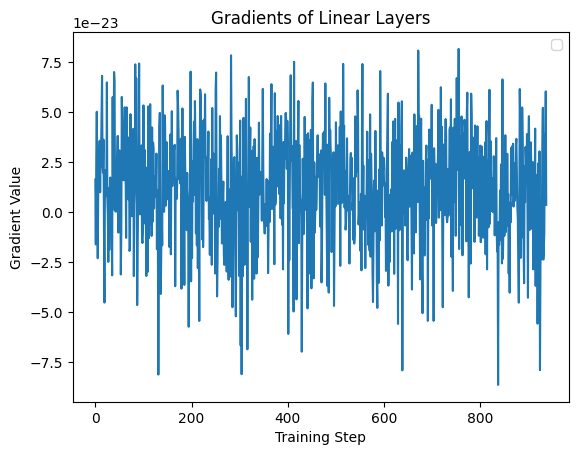

In [28]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, магнитуда градиента стала слишком большой, что приводит к тому, что модель не может сойтись (достичь минимума).

# ResNet

Теперь давайте попробуем реализовать модель ResNet. Ее авторы нашли способ как бороться с проблемой затухания градиента в глубоких сетях используя так называемые shortcut (или residual) связи между слоями.

**Задача 7:** Определите Residual Block

In [29]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

**Вопрос:** Посчитайте и выведите сумму выходов ResidualBlock(10,10) для рандомного входного тензора test_input.

**Пример ответа:** `1.234`

In [30]:
torch.manual_seed(42)
test_input = torch.rand((1, 10, 3, 28*28))
res_block = ResidualBlock(10,10)
answer = res_block(test_input).sum().item()
answer   # 16789.064453125

16789.064453125

**Задача 8:** Теперь определите модель ResNet, состоящую из нескольких ResidualBlock

In [31]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=1)
        self.layer3 = self._make_layer(128, 256, 2, stride=1)
        self.fc = nn.Linear(2304, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(ResidualBlock(in_channels, out_channels, stride))
            else:
                layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

**Вопрос:** Посчитайте и выведите количество параметров (весов) этой ResNet модели

**Пример ответа:** `43242`

In [32]:
model = ResNet()

answer = sum(param.numel() for param in model.parameters())
answer   # 2799114

2799114

In [33]:
# Инициализируем объект класса модели ResNet, а также лосс функцию и оптимайзер:
torch.manual_seed(42)

model = ResNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [34]:
# Теперь обучите эту модель:
torch.manual_seed(42)

model.train()

fc_gradients = []

for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

    fc_gradients.append(model.fc.weight.grad.mean().item())

  0%|          | 1/938 [00:04<1:03:30,  4.07s/it]

Step: 0, Loss: 2.4625656604766846


  1%|          | 11/938 [00:20<24:52,  1.61s/it] 

Step: 10, Loss: 4.5103983879089355


  2%|▏         | 21/938 [00:36<25:06,  1.64s/it]

Step: 20, Loss: 2.2107760906219482


  3%|▎         | 31/938 [00:55<29:00,  1.92s/it]

Step: 30, Loss: 1.411897897720337


  4%|▍         | 41/938 [01:14<29:01,  1.94s/it]

Step: 40, Loss: 1.091172695159912


  5%|▌         | 51/938 [01:34<28:50,  1.95s/it]

Step: 50, Loss: 0.9080399870872498


  7%|▋         | 61/938 [01:53<28:33,  1.95s/it]

Step: 60, Loss: 0.41122278571128845


  8%|▊         | 71/938 [02:12<27:45,  1.92s/it]

Step: 70, Loss: 0.2149762660264969


  9%|▊         | 81/938 [02:30<24:22,  1.71s/it]

Step: 80, Loss: 0.22646206617355347


 10%|▉         | 91/938 [02:46<23:17,  1.65s/it]

Step: 90, Loss: 0.2849991023540497


 11%|█         | 101/938 [03:03<23:21,  1.67s/it]

Step: 100, Loss: 0.23421326279640198


 12%|█▏        | 111/938 [03:20<22:59,  1.67s/it]

Step: 110, Loss: 0.37184637784957886


 13%|█▎        | 121/938 [03:37<23:32,  1.73s/it]

Step: 120, Loss: 0.43875983357429504


 14%|█▍        | 131/938 [03:55<24:00,  1.78s/it]

Step: 130, Loss: 0.226155623793602


 15%|█▌        | 141/938 [04:12<23:10,  1.74s/it]

Step: 140, Loss: 0.35349154472351074


 16%|█▌        | 151/938 [04:30<23:57,  1.83s/it]

Step: 150, Loss: 0.09922107309103012


 17%|█▋        | 161/938 [04:48<22:22,  1.73s/it]

Step: 160, Loss: 0.11071154475212097


 18%|█▊        | 171/938 [05:05<21:21,  1.67s/it]

Step: 170, Loss: 0.3474343717098236


 19%|█▉        | 181/938 [05:22<21:06,  1.67s/it]

Step: 180, Loss: 0.11588083952665329


 20%|██        | 191/938 [05:38<20:46,  1.67s/it]

Step: 190, Loss: 0.3011220693588257


 21%|██▏       | 201/938 [05:55<20:20,  1.66s/it]

Step: 200, Loss: 0.1757158488035202


 22%|██▏       | 211/938 [06:11<20:12,  1.67s/it]

Step: 210, Loss: 0.2233523577451706


 24%|██▎       | 221/938 [06:28<20:04,  1.68s/it]

Step: 220, Loss: 0.12048191577196121


 25%|██▍       | 231/938 [06:45<19:35,  1.66s/it]

Step: 230, Loss: 0.1386527121067047


 26%|██▌       | 241/938 [07:01<19:07,  1.65s/it]

Step: 240, Loss: 0.07963859289884567


 27%|██▋       | 251/938 [07:17<18:44,  1.64s/it]

Step: 250, Loss: 0.11858658492565155


 28%|██▊       | 261/938 [07:34<18:20,  1.63s/it]

Step: 260, Loss: 0.12271543592214584


 29%|██▉       | 271/938 [07:50<18:02,  1.62s/it]

Step: 270, Loss: 0.04779078811407089


 30%|██▉       | 281/938 [08:07<17:54,  1.64s/it]

Step: 280, Loss: 0.11169086396694183


 31%|███       | 291/938 [08:23<17:49,  1.65s/it]

Step: 290, Loss: 0.1586586982011795


 32%|███▏      | 301/938 [08:40<17:33,  1.65s/it]

Step: 300, Loss: 0.18893909454345703


 33%|███▎      | 311/938 [08:57<18:18,  1.75s/it]

Step: 310, Loss: 0.10505879670381546


 34%|███▍      | 321/938 [09:15<18:16,  1.78s/it]

Step: 320, Loss: 0.07393410801887512


 35%|███▌      | 331/938 [09:32<17:08,  1.69s/it]

Step: 330, Loss: 0.12428287416696548


 36%|███▋      | 341/938 [09:49<17:22,  1.75s/it]

Step: 340, Loss: 0.1240445002913475


 37%|███▋      | 351/938 [10:06<16:55,  1.73s/it]

Step: 350, Loss: 0.03111952170729637


 38%|███▊      | 361/938 [10:23<16:42,  1.74s/it]

Step: 360, Loss: 0.10447102785110474


 40%|███▉      | 371/938 [10:41<16:29,  1.74s/it]

Step: 370, Loss: 0.01091691292822361


 41%|████      | 381/938 [10:58<16:19,  1.76s/it]

Step: 380, Loss: 0.04512595385313034


 42%|████▏     | 391/938 [11:16<16:00,  1.76s/it]

Step: 390, Loss: 0.28907057642936707


 43%|████▎     | 401/938 [11:34<15:57,  1.78s/it]

Step: 400, Loss: 0.1402895748615265


 44%|████▍     | 411/938 [11:51<15:39,  1.78s/it]

Step: 410, Loss: 0.03656690940260887


 45%|████▍     | 421/938 [12:09<15:19,  1.78s/it]

Step: 420, Loss: 0.13193798065185547


 46%|████▌     | 431/938 [12:27<15:12,  1.80s/it]

Step: 430, Loss: 0.029789460822939873


 47%|████▋     | 441/938 [12:46<16:31,  2.00s/it]

Step: 440, Loss: 0.09047671407461166


 48%|████▊     | 451/938 [13:06<15:45,  1.94s/it]

Step: 450, Loss: 0.07719922810792923


 49%|████▉     | 461/938 [13:25<15:21,  1.93s/it]

Step: 460, Loss: 0.17339131236076355


 50%|█████     | 471/938 [13:44<14:39,  1.88s/it]

Step: 470, Loss: 0.08152828365564346


 51%|█████▏    | 481/938 [14:02<14:02,  1.84s/it]

Step: 480, Loss: 0.024385910481214523


 52%|█████▏    | 491/938 [14:20<13:42,  1.84s/it]

Step: 490, Loss: 0.05153815820813179


 53%|█████▎    | 501/938 [14:39<13:22,  1.84s/it]

Step: 500, Loss: 0.12441807985305786


 54%|█████▍    | 511/938 [14:57<12:47,  1.80s/it]

Step: 510, Loss: 0.1146480068564415


 56%|█████▌    | 521/938 [15:15<12:39,  1.82s/it]

Step: 520, Loss: 0.1702808290719986


 57%|█████▋    | 531/938 [15:33<12:09,  1.79s/it]

Step: 530, Loss: 0.1048821210861206


 58%|█████▊    | 541/938 [15:51<11:52,  1.79s/it]

Step: 540, Loss: 0.09232143312692642


 59%|█████▊    | 551/938 [16:09<11:44,  1.82s/it]

Step: 550, Loss: 0.1135256215929985


 60%|█████▉    | 561/938 [16:28<11:49,  1.88s/it]

Step: 560, Loss: 0.061678197234869


 61%|██████    | 571/938 [16:47<12:00,  1.96s/it]

Step: 570, Loss: 0.15216201543807983


 62%|██████▏   | 581/938 [17:06<10:43,  1.80s/it]

Step: 580, Loss: 0.2938297688961029


 63%|██████▎   | 591/938 [17:25<11:11,  1.93s/it]

Step: 590, Loss: 0.2872453033924103


 64%|██████▍   | 601/938 [17:46<12:03,  2.15s/it]

Step: 600, Loss: 0.23870159685611725


 65%|██████▌   | 611/938 [18:07<10:53,  2.00s/it]

Step: 610, Loss: 0.0729936957359314


 66%|██████▌   | 621/938 [18:28<11:14,  2.13s/it]

Step: 620, Loss: 0.08349067717790604


 67%|██████▋   | 631/938 [18:49<10:13,  2.00s/it]

Step: 630, Loss: 0.28447431325912476


 68%|██████▊   | 641/938 [19:08<09:49,  1.99s/it]

Step: 640, Loss: 0.037029653787612915


 69%|██████▉   | 651/938 [19:29<09:28,  1.98s/it]

Step: 650, Loss: 0.08739032596349716


 70%|███████   | 661/938 [19:49<09:21,  2.03s/it]

Step: 660, Loss: 0.14417877793312073


 72%|███████▏  | 671/938 [20:09<08:44,  1.97s/it]

Step: 670, Loss: 0.06814740598201752


 73%|███████▎  | 681/938 [20:29<08:56,  2.09s/it]

Step: 680, Loss: 0.09585817903280258


 74%|███████▎  | 691/938 [20:51<08:45,  2.13s/it]

Step: 690, Loss: 0.14920325577259064


 75%|███████▍  | 701/938 [21:12<08:25,  2.13s/it]

Step: 700, Loss: 0.05074405297636986


 76%|███████▌  | 711/938 [21:33<07:48,  2.07s/it]

Step: 710, Loss: 0.0379471629858017


 77%|███████▋  | 721/938 [21:54<07:42,  2.13s/it]

Step: 720, Loss: 0.02996273711323738


 78%|███████▊  | 731/938 [22:16<07:22,  2.14s/it]

Step: 730, Loss: 0.1399078071117401


 79%|███████▉  | 741/938 [22:37<07:02,  2.14s/it]

Step: 740, Loss: 0.10576511919498444


 80%|████████  | 751/938 [22:59<06:38,  2.13s/it]

Step: 750, Loss: 0.03590569645166397


 81%|████████  | 761/938 [23:20<06:18,  2.14s/it]

Step: 760, Loss: 0.15118753910064697


 82%|████████▏ | 771/938 [23:41<05:54,  2.13s/it]

Step: 770, Loss: 0.11966618150472641


 83%|████████▎ | 781/938 [24:02<05:32,  2.12s/it]

Step: 780, Loss: 0.21145150065422058


 84%|████████▍ | 791/938 [24:24<05:12,  2.13s/it]

Step: 790, Loss: 0.15883204340934753


 85%|████████▌ | 801/938 [24:45<04:47,  2.10s/it]

Step: 800, Loss: 0.08682234585285187


 86%|████████▋ | 811/938 [25:06<04:28,  2.12s/it]

Step: 810, Loss: 0.012737792916595936


 88%|████████▊ | 821/938 [25:27<04:07,  2.11s/it]

Step: 820, Loss: 0.18062813580036163


 89%|████████▊ | 831/938 [25:48<03:44,  2.10s/it]

Step: 830, Loss: 0.07716773450374603


 90%|████████▉ | 841/938 [26:09<03:25,  2.12s/it]

Step: 840, Loss: 0.2620786428451538


 91%|█████████ | 851/938 [26:30<03:03,  2.11s/it]

Step: 850, Loss: 0.08749246597290039


 92%|█████████▏| 861/938 [26:51<02:41,  2.10s/it]

Step: 860, Loss: 0.050141289830207825


 93%|█████████▎| 871/938 [27:12<02:21,  2.11s/it]

Step: 870, Loss: 0.08688332140445709


 94%|█████████▍| 881/938 [27:33<02:00,  2.11s/it]

Step: 880, Loss: 0.05685518682003021


 95%|█████████▍| 891/938 [27:54<01:39,  2.11s/it]

Step: 890, Loss: 0.018863815814256668


 96%|█████████▌| 901/938 [28:16<01:18,  2.11s/it]

Step: 900, Loss: 0.10938555747270584


 97%|█████████▋| 911/938 [28:37<00:56,  2.10s/it]

Step: 910, Loss: 0.22255322337150574


 98%|█████████▊| 921/938 [28:58<00:36,  2.14s/it]

Step: 920, Loss: 0.0836317390203476


 99%|█████████▉| 931/938 [29:19<00:14,  2.10s/it]

Step: 930, Loss: 0.19586260616779327


100%|██████████| 938/938 [29:33<00:00,  1.89s/it]


Как можете видеть, лосс продолжает уменьшаться. Теперь попробуйте визиулизировать градиент накопленный в переменной fc_gradients

C:\Users\khari\AppData\Local\Temp\ipykernel_2364\2019969697.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


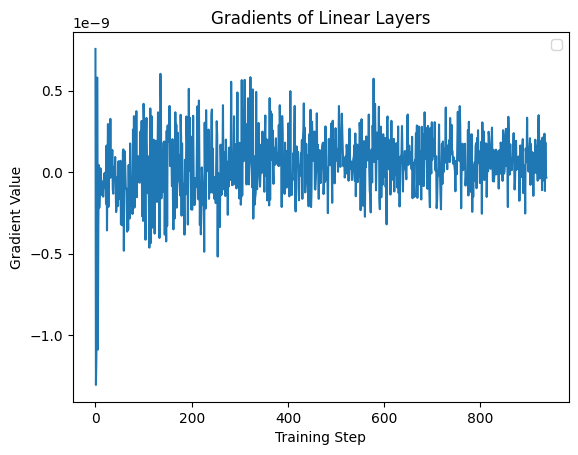

In [36]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Теперь градиент кажется достаточно стабильным, и это позволяет ResNet модели обучаться лучше предыдущей модели, которая была подвержена проблеме затухания градента. Таким способом ResNet стала SOTA моделью в 2015 году и выиграла ImageNet competition.

Наконец, давайте сохраним параметры (веса) обученной модели чтобы переиспользовать их позже:

In [37]:
checkpoint_path = './mnist_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)

# Transfer Learning

Перед тем как мы перейдем к технике обучения называемой Transfer Learning, давайте сперва протестируем нашу модель на тестовой подвыборке датасета MNIST. Чтобы сделать это, вам необходимо скачать тестовую подвыборку схожим образом, как вы уже скачали подвыборку для обучения с тем отличием, что нужно изменить параметр `train=False`:

In [38]:
# Загрузите тестовую подвыборку датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Теперь нам нужно имплементировать функцию для тестирования модели, в которой мы будем считать точность (accuracy) нашей модели (т.е. процент правильных предсказаний):

In [39]:
def test(model, dataloader):
  model.eval()

  with torch.no_grad():
    correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        
    accuracy = correct/len(dataloader.dataset)

    return accuracy

Теперь загрузите ранее сохраненные параметры (веса) обученной ResNet модели:

**Задача 9:** Посчитайте точность модели на тесте.

In [40]:
model = ResNet()
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

**Вопрос:** Посчитайте и выведите точность модели на тестовой выборке MNIST.

**Пример ответа:** `22.45`

In [41]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  

100%|██████████| 157/157 [01:40<00:00,  1.57it/s]


MNIST test accuracy: 97.34%


Вы должны получить точность примерно 96% или выше.

Теперь давайте попробуем загрузить другой датасет - CIFAR10, который состоит из 10 классов, но содержит изображения не рукописаных цифр, а объектов (horses, dogs, cars, и др.). Изображения имеют размер 32x32 и три цветовых канала (RGB). Поэтому нам также нужно изменить трансформации (transforms), чтобы изображения CIFAR10 соответствовали  изображениям MNIST (т.е. 28x28 в формате grayscale):

In [42]:
# Трансформации для датасета CIFAR10:
transform_cifar10 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Выборка для обучения:
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_cifar10)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=True, num_workers=2)

# Выборка для тестирования:
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_cifar10)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:22<00:00, 7.60MB/s] 


Теперь протестируйте ранее обученную ResNet модель на тестовой выборке датасета CIFAR10 (пока переобучать модель не нужно!):

**Задача 10:** Протестируйте модель на тестовой выборке CIFAR10

**Вопрос:** Посчитайте и выведите точность модели на тесте

**Пример ответа:** `22.45`

In [43]:
accuracy = test(model, testloader_cifar10)
print(f"\nTest accuracy: {100*accuracy}%")  

100%|██████████| 157/157 [01:38<00:00,  1.60it/s]


Test accuracy: 10.03%


Как видите, точность на CIFAR10 не очень большая (около 10%). И это не удивительно, ведь мы обучали нашу ResNet модель на другом датасете (MNIST).

Теперь давайте заморозим все слои за исключением последнего (т.е. слоя классификации):

**Задача 11:** Заморозьте слои модели кроме последнего

In [45]:
for param in model.parameters():
    param.requires_grad = False              # отключаем градиент (т.е. "замораживаем" слои)
    
mnist_fc = model.fc                          # Сохраняем в переменную слой классификации MNIST
in_features = model.fc.in_features         
model.fc = torch.nn.Linear(in_features, 10)  # Создаем новый слой классификации для CIFAR10
#model.fc = model.fc.cuda()

**Вопрос:** Посчитайте и выведите количество параметров (весов) в замороженных слоях

**Пример ответа:** `224513`

In [46]:
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
frozen_params   # 2776064

2776064

**Задача 12:** Обучите только последний слой модели на датасете CIFAR10 (все остальные слои должны быть заморожены)

In [47]:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for step, data in tqdm(enumerate(trainloader_cifar10), total=len(trainloader_cifar10)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

  0%|          | 1/782 [00:00<08:33,  1.52it/s]

Step: 0, Loss: 2.3461034297943115


  1%|▏         | 11/782 [00:07<08:23,  1.53it/s]

Step: 10, Loss: 2.9652345180511475


  3%|▎         | 21/782 [00:13<08:19,  1.52it/s]

Step: 20, Loss: 2.482700824737549


  4%|▍         | 31/782 [00:20<08:33,  1.46it/s]

Step: 30, Loss: 2.428250551223755


  5%|▌         | 41/782 [00:27<08:35,  1.44it/s]

Step: 40, Loss: 2.2897086143493652


  7%|▋         | 51/782 [00:34<08:29,  1.43it/s]

Step: 50, Loss: 2.1709046363830566


  8%|▊         | 61/782 [00:41<08:19,  1.44it/s]

Step: 60, Loss: 2.1335604190826416


  9%|▉         | 71/782 [00:48<08:15,  1.43it/s]

Step: 70, Loss: 1.9525202512741089


 10%|█         | 81/782 [00:55<08:13,  1.42it/s]

Step: 80, Loss: 2.0342023372650146


 12%|█▏        | 91/782 [01:02<08:01,  1.44it/s]

Step: 90, Loss: 2.509056806564331


 13%|█▎        | 101/782 [01:08<07:41,  1.48it/s]

Step: 100, Loss: 1.8697216510772705


 14%|█▍        | 111/782 [01:15<07:31,  1.49it/s]

Step: 110, Loss: 2.126199722290039


 15%|█▌        | 121/782 [01:22<07:37,  1.44it/s]

Step: 120, Loss: 1.8203842639923096


 17%|█▋        | 131/782 [01:29<07:33,  1.44it/s]

Step: 130, Loss: 2.21370267868042


 18%|█▊        | 141/782 [01:36<07:25,  1.44it/s]

Step: 140, Loss: 2.3148727416992188


 19%|█▉        | 151/782 [01:43<07:15,  1.45it/s]

Step: 150, Loss: 2.1221375465393066


 21%|██        | 161/782 [01:50<07:03,  1.47it/s]

Step: 160, Loss: 1.9882745742797852


 22%|██▏       | 171/782 [01:57<07:10,  1.42it/s]

Step: 170, Loss: 2.015211820602417


 23%|██▎       | 181/782 [02:04<07:02,  1.42it/s]

Step: 180, Loss: 2.105300188064575


 24%|██▍       | 191/782 [02:11<06:54,  1.43it/s]

Step: 190, Loss: 1.976637363433838


 26%|██▌       | 201/782 [02:18<06:50,  1.42it/s]

Step: 200, Loss: 2.2747817039489746


 27%|██▋       | 211/782 [02:25<06:28,  1.47it/s]

Step: 210, Loss: 1.6906942129135132


 28%|██▊       | 221/782 [02:32<06:36,  1.41it/s]

Step: 220, Loss: 2.1290438175201416


 30%|██▉       | 231/782 [02:39<06:25,  1.43it/s]

Step: 230, Loss: 1.9175174236297607


 31%|███       | 241/782 [02:46<06:19,  1.43it/s]

Step: 240, Loss: 1.8013073205947876


 32%|███▏      | 251/782 [02:53<06:13,  1.42it/s]

Step: 250, Loss: 2.1135456562042236


 33%|███▎      | 261/782 [03:00<06:04,  1.43it/s]

Step: 260, Loss: 2.1814393997192383


 35%|███▍      | 271/782 [03:07<06:00,  1.42it/s]

Step: 270, Loss: 2.218353509902954


 36%|███▌      | 281/782 [03:14<05:56,  1.41it/s]

Step: 280, Loss: 1.9534910917282104


 37%|███▋      | 291/782 [03:21<05:47,  1.41it/s]

Step: 290, Loss: 2.23136568069458


 38%|███▊      | 301/782 [03:28<05:37,  1.42it/s]

Step: 300, Loss: 2.05511474609375


 40%|███▉      | 311/782 [03:35<05:34,  1.41it/s]

Step: 310, Loss: 2.120335102081299


 41%|████      | 321/782 [03:42<05:26,  1.41it/s]

Step: 320, Loss: 2.0305209159851074


 42%|████▏     | 331/782 [03:49<05:17,  1.42it/s]

Step: 330, Loss: 2.0353214740753174


 44%|████▎     | 341/782 [03:56<05:10,  1.42it/s]

Step: 340, Loss: 1.9863307476043701


 45%|████▍     | 351/782 [04:03<05:06,  1.41it/s]

Step: 350, Loss: 1.9890167713165283


 46%|████▌     | 361/782 [04:10<04:59,  1.41it/s]

Step: 360, Loss: 1.8908263444900513


 47%|████▋     | 371/782 [04:17<04:50,  1.41it/s]

Step: 370, Loss: 1.9586851596832275


 49%|████▊     | 381/782 [04:24<04:44,  1.41it/s]

Step: 380, Loss: 1.6932984590530396


 50%|█████     | 391/782 [04:31<04:39,  1.40it/s]

Step: 390, Loss: 2.081510066986084


 51%|█████▏    | 401/782 [04:39<04:29,  1.41it/s]

Step: 400, Loss: 1.8067208528518677


 53%|█████▎    | 411/782 [04:46<04:23,  1.41it/s]

Step: 410, Loss: 2.4364917278289795


 54%|█████▍    | 421/782 [04:53<04:15,  1.41it/s]

Step: 420, Loss: 2.362832546234131


 55%|█████▌    | 431/782 [05:00<04:03,  1.44it/s]

Step: 430, Loss: 1.8990422487258911


 56%|█████▋    | 441/782 [05:07<03:55,  1.45it/s]

Step: 440, Loss: 1.8345296382904053


 58%|█████▊    | 451/782 [05:14<03:49,  1.44it/s]

Step: 450, Loss: 2.314401149749756


 59%|█████▉    | 461/782 [05:21<03:44,  1.43it/s]

Step: 460, Loss: 2.214080333709717


 60%|██████    | 471/782 [05:28<03:33,  1.46it/s]

Step: 470, Loss: 2.0801584720611572


 62%|██████▏   | 481/782 [05:35<03:26,  1.46it/s]

Step: 480, Loss: 2.1412980556488037


 63%|██████▎   | 491/782 [05:42<03:19,  1.46it/s]

Step: 490, Loss: 1.8159644603729248


 64%|██████▍   | 501/782 [05:49<03:12,  1.46it/s]

Step: 500, Loss: 2.297985553741455


 65%|██████▌   | 511/782 [05:55<03:06,  1.45it/s]

Step: 510, Loss: 2.3101985454559326


 67%|██████▋   | 521/782 [06:02<02:59,  1.46it/s]

Step: 520, Loss: 2.556901216506958


 68%|██████▊   | 531/782 [06:09<02:45,  1.52it/s]

Step: 530, Loss: 2.37463116645813


 69%|██████▉   | 541/782 [06:16<02:51,  1.40it/s]

Step: 540, Loss: 2.2625892162323


 70%|███████   | 551/782 [06:22<02:23,  1.61it/s]

Step: 550, Loss: 2.463909387588501


 72%|███████▏  | 561/782 [06:28<02:18,  1.59it/s]

Step: 560, Loss: 2.0635688304901123


 73%|███████▎  | 571/782 [06:34<02:07,  1.66it/s]

Step: 570, Loss: 2.047329902648926


 74%|███████▍  | 581/782 [06:41<02:03,  1.63it/s]

Step: 580, Loss: 2.119675397872925


 76%|███████▌  | 591/782 [06:47<01:57,  1.62it/s]

Step: 590, Loss: 2.220097541809082


 77%|███████▋  | 601/782 [06:53<01:55,  1.56it/s]

Step: 600, Loss: 1.9906079769134521


 78%|███████▊  | 611/782 [06:59<01:44,  1.64it/s]

Step: 610, Loss: 1.7247488498687744


 79%|███████▉  | 621/782 [07:05<01:37,  1.65it/s]

Step: 620, Loss: 2.1583597660064697


 81%|████████  | 631/782 [07:12<01:31,  1.64it/s]

Step: 630, Loss: 2.359983444213867


 82%|████████▏ | 641/782 [07:18<01:36,  1.46it/s]

Step: 640, Loss: 1.9835803508758545


 83%|████████▎ | 651/782 [07:25<01:35,  1.38it/s]

Step: 650, Loss: 1.9007700681686401


 85%|████████▍ | 661/782 [07:32<01:19,  1.53it/s]

Step: 660, Loss: 1.6317229270935059


 86%|████████▌ | 671/782 [07:38<01:15,  1.47it/s]

Step: 670, Loss: 2.2344250679016113


 87%|████████▋ | 681/782 [07:45<01:06,  1.52it/s]

Step: 680, Loss: 2.4253783226013184


 88%|████████▊ | 691/782 [07:52<01:03,  1.43it/s]

Step: 690, Loss: 2.1479432582855225


 90%|████████▉ | 701/782 [07:59<00:55,  1.47it/s]

Step: 700, Loss: 1.8369780778884888


 91%|█████████ | 711/782 [08:06<00:47,  1.51it/s]

Step: 710, Loss: 2.1988883018493652


 92%|█████████▏| 721/782 [08:12<00:39,  1.55it/s]

Step: 720, Loss: 2.1740121841430664


 93%|█████████▎| 731/782 [08:18<00:32,  1.55it/s]

Step: 730, Loss: 2.10422420501709


 95%|█████████▍| 741/782 [08:25<00:25,  1.62it/s]

Step: 740, Loss: 1.9244130849838257


 96%|█████████▌| 751/782 [08:31<00:20,  1.52it/s]

Step: 750, Loss: 1.910300850868225


 97%|█████████▋| 761/782 [08:38<00:13,  1.56it/s]

Step: 760, Loss: 2.3527157306671143


 99%|█████████▊| 771/782 [08:44<00:06,  1.58it/s]

Step: 770, Loss: 2.139540433883667


100%|██████████| 782/782 [08:50<00:00,  2.07it/s]

Step: 780, Loss: 1.981054663658142


100%|██████████| 782/782 [08:51<00:00,  1.47it/s]


**Вопрос:** Посчитайте точность на тестовой выборке CIFAR10

**Пример ответа:** `32.45`

In [48]:
accuracy = test(model, testloader_cifar10)
print(f"\nTest accuracy: {100*accuracy}%")   

100%|██████████| 157/157 [01:37<00:00,  1.60it/s]


Test accuracy: 37.41%


Как можете видеть, точность модели выросла до примерно 35%. Мы обучили только последний слой (классификации), а остальная часть сети осталось нетронутой (т.е. остальные слои обучены на датасете MNIST). Эта техника обучения и называется Transfer Learning.

Теперь протестируйте эту модель еще раз на тестовой выборке MNIST:

In [49]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  

100%|██████████| 157/157 [01:32<00:00,  1.70it/s]


MNIST test accuracy: 4.279999999999999%


Как вы можете видеть, точность упала ниже 10%, поскольку последний слой классификации теперь обучен на CIFAR10 датасете. Это называется "катастрофическим забыванием" (catastrophic forgetting). Катастрофическое забывание это тенденация нейронной сети забывать предыдущие обученные знания когда она обучается новой информации.

Наконец, давайте вернем назад ранее сохраненный слой классификации обученный на MNIST и протестируем еще раз:

**Задача 13:** Верните последний слой mnist_fc и проведите финальный тест на тестовых выборках MNIST и CIFAR10

**Вопрос:** Посчитайте и выведите точность на тестовых выборках MNIST и CIFAR10

**Пример ответа:** 
`CIFAR test accuracy: 9.45`
`MNIST test accuracy: 51.68`

In [50]:
cifar_fc = model.fc

In [52]:

model.fc = mnist_fc # верните в модель слой классификации обученный на MNIST
#model.fc = model.fc.cuda()                # Перенесем на cuda

accuracy = test(model, testloader_cifar10)
print(f"\nCIFAR test accuracy: {100*accuracy}%")

accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  

100%|██████████| 157/157 [01:27<00:00,  1.80it/s]



CIFAR test accuracy: 10.67%


100%|██████████| 157/157 [01:31<00:00,  1.71it/s]


MNIST test accuracy: 3.8%
